Walk through of Iowa Liquor.

** This by no means represents to the 'right', 'correct', or 'perfect' way to do this project. This code exists to give a refference for process / workflow and some advanced techniques in a setting, dataset, and problem you're familiar with **

#### Import and Clean

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# Import, convert 'Date' col to datetime
liquor=pd.read_csv('../Assets/Iowa_Liquor_sample.csv',parse_dates=['Date'],infer_datetime_format=True)

# format column names
import re

liquor.columns = [re.sub("[^a-zA-Z]+", "", x) for x in liquor.columns]

# remove '$' in values and convert to numeric
adjust_cols = ['StateBottleCost','StateBottleRetail','SaleDollars']

for col in adjust_cols:
    liquor[col] = pd.to_numeric(liquor[col].str.replace('$',''),errors='coerce')

liquor.dropna(inplace=True)

In [3]:
liquor.head()

,Date,StoreNumber,City,ZipCode,CountyNumber,County,Category,CategoryName,VendorNumber,ItemNumber,ItemDescription,BottleVolumeml,StateBottleCost,StateBottleRetail,BottlesSold,SaleDollars,VolumeSoldLiters,VolumeSoldGallons
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2.38
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,13.75,20.63,2,41.26,1.5,0.40
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,12.59,18.89,24,453.36,24.0,6.34
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,9.50,14.25,6,85.50,10.5,2.77
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,7.20,10.80,12,129.60,21.0,5.55


### Filtering dates

I want to end up with 2 dataframes:

* *liquor2015_fy* - with just StoreNumber and total sales for 2015
* *liquor2015_q1* - all columns, only Q1 of 2015

First I'll filter to 2015, then split into fy / q1

In [13]:
# Filter to only 2015:
liquor2015 = liquor[liquor.Date.dt.year == 2015]

In [14]:
# Calculate the sum of sales for each store in 2015 by grouping the full year data
liquor2015_fy = liquor2015.groupby('StoreNumber').sum().reset_index()[['StoreNumber','SaleDollars']]

In [15]:
# Filter all my columns to Q1
liquor2015_q1 = liquor2015[liquor2015.Date.dt.month <= 3]

### Feature Engineering

I'm going to calculate profit. Because I'll be aggregating by store over the period (q1), and my data is in the form of daily purchases by product by store, in order to get representive aggreate metrics for profit I'm going to calculate it as Total Sales -(Bottles Sold * Bottle Cost)

Then, I'm going to create a dictionary continaing the aggregations I'd like to explore, which I can then pass to my groupby using the .agg method

In [16]:
liquor2015_q1['Profit'] = liquor2015_q1.SaleDollars - (liquor2015_q1.BottlesSold * liquor2015_q1.StateBottleCost)

C:\Users\jtate\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [19]:
# agg will take a dict in the form of {'Column':[list of agg functions]}
agg_dict = {'BottleVolumeml':np.mean,
'StateBottleCost':[np.mean,np.sum],
'SaleDollars':[np.sum,np.mean],
'Profit':[np.median,np.mean,np.sum]}

In [18]:
lq_2015_q1_gp = liquor2015_q1.groupby('StoreNumber').agg(agg_dict)

In [20]:
# this comes out with StoreNumber as my index, I'll reset it
features_q1 = lq_2015_q1_gp.reset_index()

In [21]:
# My column names are split. I'll process through them to get single feature names
features_q1.columns = [['_'.join(col).rstrip('_') for col in features_q1.columns.values]]

In [22]:
# Rename my dataframe
liquor2015_q1_features = features_q1.copy()

In [23]:
# Merge my features and my target on the 'StoreNumber' column
liquor2015_combined = pd.merge(liquor2015_q1_features,liquor2015_fy,on=['StoreNumber'])

### Modeling / Cross Val

Step 1 is to split 10% of my data off as a holdout set. I'll engineer my model on the training set using cross validation and other techniques.

Once I think my model is working well, I'll try it against the holdout set to validate my model

In [27]:
#holdout set

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
training_data,holdout = train_test_split(liquor2015_combined,shuffle=True,test_size=0.10,random_state=123)

#### Cross Val

In [30]:
from sklearn.cross_validation import KFold

C:\Users\jtate\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [31]:
# 5 fold KFolds cross-validation
folds = 5

n = training_data.shape[0]

kf = KFold(n,n_folds=folds,random_state=123)

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import numpy as np

In [33]:
# create a 'feature cols' list of column names, excluding my target and the store number (which is sorta my index)
feature_cols = [col for col in liquor2015_combined.columns if col not in ['SaleDollars','StoreNumber']]

In [34]:
feature_cols

['Profit_median',
 'Profit_mean',
 'Profit_sum',
 'StateBottleCost_mean',
 'StateBottleCost_sum',
 'SaleDollars_sum',
 'SaleDollars_mean',
 'BottleVolumeml_mean']

In [37]:
# Prep my X and y
X = training_data[feature_cols]
y = training_data['StoreNumber']


In [38]:
# Iterate through my folds. Right now I'm just going to look at mse and r2

scores = []
r2_scores = []


for train,test in kf:
    x_train = X.iloc[train]
    x_test = X.iloc[test]
    y_train = y.iloc[train]
    y_true = y.iloc[test]
    
    lr = LinearRegression()
    
    lr.fit(x_train,y_train)
    
    y_preds = lr.predict(x_test)

    scores.append(mean_squared_error(y_true,y_preds))
    r2_scores.append(r2_score(y_true,y_preds))


In [39]:
# check RMSE to see how I'm doing in values scalled to my target

rmse = [np.sqrt(x) for x in scores]

print rmse
print np.mean(rmse)

[606.26612671541659, 625.06315266478055, 694.5336059147179, 638.56768656809959, 624.03697016943283]
637.693508406


In [40]:
print r2_scores
print np.mean(r2_scores)

[0.39055933036578117, 0.41164252546358049, 0.31691086909492971, 0.35867894679955548, 0.41398316336448826]
0.378354967018


#### Evaluate

My RMSE is good. Really good. Maybe too good? But my r-squared is awful. If I'm predicting only 600-670 off my target, when that target is in the 10's to 100's of thousands, I should have a great r-squared to match... but I don't

I didn't check my features for colinearity... lets look

In [44]:
# Quick function 
def pair_corrs(df):
    #get pairwise correlation dataframe
    corrs1 = df.corr()
    # df.corr() has 2 pairs (A x B and B x A) for each feature set.
    # np.tril zeroes out one of the 'triangles' in my pairwise dataframe
    # k=-1 cuts not only the 2nd pairing of each feature, but also the N vs. N identity line
    corrs1.loc[:, :] = np.tril(corrs1, k=-1)
    #stack my index
    corr_pairs = corrs1.stack()
    #return my pairs
    return corr_pairs


In [63]:
# get the correlations from my X dataframe
feature_corrs = pair_corrs(X)

# check for large correlations
feature_corrs[(abs(feature_corrs) > 0.5)]


Profit_mean  Profit_median    0.85479
dtype: float64

Those are some high correlations. I'm going to prune some of my features to reduce colinearity

In [67]:
# prune my features to reduce colinearity
feature_cols2 = [x for x in feature_cols if x not in ['Profit_sum','Profit_mean','StateBottleCost_sum','SaleDollars_mean']]

In [68]:
# check my pruned features
pair_corrs(training_data[feature_cols2])

Profit_median         Profit_median           0.000000
                      StateBottleCost_mean    0.000000
                      SaleDollars_sum         0.000000
                      BottleVolumeml_mean     0.000000
StateBottleCost_mean  Profit_median           0.277697
                      StateBottleCost_mean    0.000000
                      SaleDollars_sum         0.000000
                      BottleVolumeml_mean     0.000000
SaleDollars_sum       Profit_median           0.195495
                      StateBottleCost_mean    0.210101
                      SaleDollars_sum         0.000000
                      BottleVolumeml_mean     0.000000
BottleVolumeml_mean   Profit_median           0.135616
                      StateBottleCost_mean    0.456472
                      SaleDollars_sum         0.079048
                      BottleVolumeml_mean     0.000000
dtype: float64

In [69]:
feature_cols2

['Profit_median',
 'StateBottleCost_mean',
 'SaleDollars_sum',
 'BottleVolumeml_mean']

Better.

re-run my model:

In [70]:
X = training_data[feature_cols2]
y = training_data['SaleDollars']

In [71]:
kf = KFold(X.shape[0],n_folds=5,random_state=117)

In [72]:
scores = []
r2_scores = []


for train,test in kf:
    x_train = X.iloc[train]
    x_test = X.iloc[test]
    y_train = y.iloc[train]
    y_true = y.iloc[test]
    
    lr.fit(x_train,y_train)
    
    y_preds = lr.predict(x_test)

    scores.append(mean_squared_error(y_true,y_preds))
    r2_scores.append(r2_score(y_true,y_preds))

In [73]:
print r2_scores
print np.mean(r2_scores)

[0.94668173587870974, 0.94816577159677873, 0.97278213025743188, 0.97137797433860285, 0.89347033858533964]
0.946495590131


In [74]:
print [np.sqrt(x) for x in scores]
print np.mean([np.sqrt(x) for x in scores])

[8813.3399252520885, 8536.1217073653734, 11795.909489683443, 12004.963463008906, 11538.708770855244]
10537.8086712


My r-squared has improved dramatically at the expense of my RMSE

### Coefficients and Intercept

View the coefficients of your model - what do the coefficients tell you about the relationships between your features and your target?

In [75]:
lr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [76]:
list(zip(feature_cols2,lr.coef_))

[('Profit_median', 18.917775382761423),
 ('StateBottleCost_mean', 103.21825639717933),
 ('SaleDollars_sum', 4.4868534013409294),
 ('BottleVolumeml_mean', -0.0074847728176543529)]

In [77]:
lr.intercept_

-1204.0939005267792

### Tuning Your Model

So far, you've trained a basic linear model and evaluated it using Mean Squared Error. Use the same process as above to evaluate your model using: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE) and calculate the R2 score of your predictions.

Try some of the parameters available for your linear model, and different sets of features to find a model that you feel will **perform best on new, out of sample data**

In [113]:
feature_cols_new = [x for x in feature_cols if x not in ['Profit_mean','SaleDollars_mean']]

In [114]:
pair_corrs(training_data[feature_cols_new])

Profit_median         Profit_median           0.000000
                      Profit_sum              0.000000
                      StateBottleCost_mean    0.000000
                      StateBottleCost_sum     0.000000
                      SaleDollars_sum         0.000000
                      BottleVolumeml_mean     0.000000
Profit_sum            Profit_median           0.195235
                      Profit_sum              0.000000
                      StateBottleCost_mean    0.000000
                      StateBottleCost_sum     0.000000
                      SaleDollars_sum         0.000000
                      BottleVolumeml_mean     0.000000
StateBottleCost_mean  Profit_median           0.277697
                      Profit_sum              0.210177
                      StateBottleCost_mean    0.000000
                      StateBottleCost_sum     0.000000
                      SaleDollars_sum         0.000000
                      BottleVolumeml_mean     0.000000
StateBottl

In [115]:
X = training_data[feature_cols_new]
y = training_data['SaleDollars']

In [116]:
# Use K-Folds cross validation to train your model
# Evaluate your model using MAE, MSE, RMSE and R2 

In [121]:
kf = KFold(X.shape[0],random_state=123,n_folds=5)

In [122]:
mse_scores = []
mae_scores = []
r2_scores = []


for train,test in kf:
    x_train = X.iloc[train]
    x_test = X.iloc[test]
    y_train = y.iloc[train]
    y_true = y.iloc[test]
    
    lr.fit(x_train,y_train)
    
    y_preds = lr.predict(x_test)

    mse_scores.append(mean_squared_error(y_true,y_preds))
    mae_scores.append(mean_absolute_error(y_true,y_preds))
    r2_scores.append(r2_score(y_true,y_preds))


In [123]:
print r2_scores
print mse_scores

[0.96024115036419799, 0.95481619258845141, 0.97258081390414097, 0.96724662775922443, 0.91254482436488782]
[57921373.31120681, 63516620.547950238, 140172652.27281907, 164921524.0410423, 109302323.47848879]


In [124]:
print np.mean(mse_scores)
print np.mean([np.sqrt(x) for x in mse_scores])
print np.mean(mae_scores)
print np.mean(r2_scores)

107166898.73
10143.3493373
4710.25399605
0.953485921796


## Test against hold-out set

In [153]:

X_train = training_data[feature_cols_new]
y_train = training_data['SaleDollars']

x_holdout = holdout[feature_cols_new]
y_holdout = holdout['SaleDollars']

In [154]:
lr = LinearRegression()

In [155]:
# Fit your model using all of your training data
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [156]:
# Create predictions using your holdout set (x_holdout)
holdout_preds = lr.predict(x_holdout)

In [157]:
# score your model using MAE, MSE, RMSE, and R2
# hint: what is y_test and what is your y_true?

MAE_score = mean_absolute_error(y_holdout,holdout_preds)
MSE_score = mean_squared_error(y_holdout,holdout_preds)
RMSE_score = np.sqrt(MSE_score)
R2_score = r2_score(y_holdout,holdout_preds)


In [158]:
# print your scores

print MAE_score
print MSE_score
print RMSE_score
print R2_score


5489.62175593
113438625.278
10650.7570284
0.941775342657


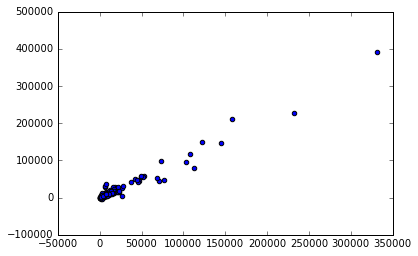

In [159]:
# Create a scatter plot of your predicted values vs. their true values
# Describe anything you observe

plt.scatter(y_holdout,holdout_preds)


In [160]:
evaldf = pd.DataFrame({'true':y_holdout,'pred':holdout_preds})

In [161]:
import seaborn as sns

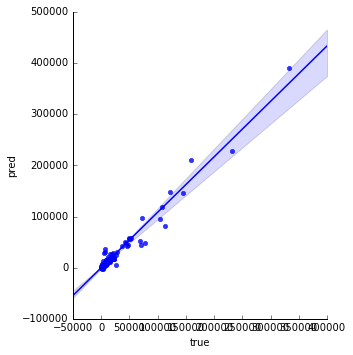

In [162]:
sns.lmplot('true','pred',evaldf)

In [163]:
# Calculate your residuals (prediction - actual)
residuals = y_holdout-holdout_preds

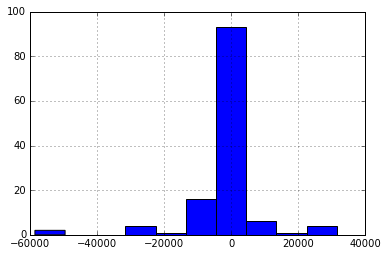

In [164]:
# Create a histogram of your residuals. Describe anything you observe

residuals.hist()

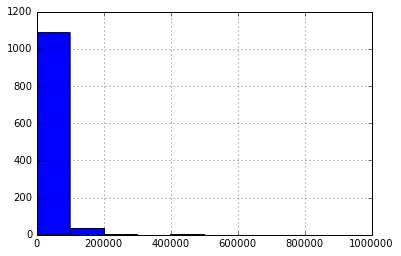

In [165]:
training_data.SaleDollars.hist()

### Takeaways:

* residuals are normally distributed, but there's some huge residuals on the upper end... looking back, I should have removed outliers
* scores changed a little but not dramatically between my training set cross-val scores and my holdout scores. That's a good sign.

### Removing outliers and trying again

In this example, instead of training my model on all my data, I'm going to maintain my cross validation, but each time I run through a training set, I'm going to predict using my holdout features, weighting them by the number of folds.

This allows me to take advantage of any subtleties my model is finding due to different samples of the data, and weights my prediction accordingly.

In [166]:
training_data[training_data.SaleDollars < 250000].shape[0]

1129

In [167]:
training_data_adj = training_data[training_data.SaleDollars < 250000]

5403.4204201
95174791.698
10650.7570284
0.951149622796


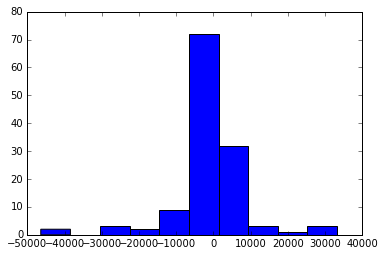

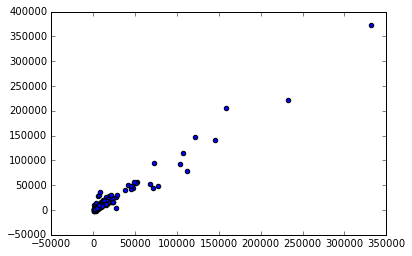

In [168]:
lr_2 = LinearRegression()

#important to have folds as a variable I can use later for weighting
folds=5
kf_2 = KFold(training_data_adj.shape[0],n_folds=folds,random_state=117)

# create a list the size of my predictions, populated with 0's which I can add to
preds = np.zeros(holdout.shape[0])

# new X and y
X_adj = training_data_adj[feature_cols_new]
y_adj = training_data_adj['SaleDollars']

# Kfolds
for tr,te in kf_2:
    x_train = X_adj.iloc[tr]
    y_train = y_adj.iloc[tr]
    lr_2.fit(x_train,y_train)
    
    #predict using my holdout x
    fold_pred = lr_2.predict(x_holdout[feature_cols_new])
    
    #add the weighted prediction (predictions divided by number of folds) to my predictions each loop
    preds +=(fold_pred/folds)

    
# Metrics
print mean_absolute_error(y_holdout,preds)
print mean_squared_error(y_holdout,preds)
print np.sqrt(MSE_score)
print r2_score(y_holdout,preds)

plt.hist(y_holdout-preds)
plt.show()

plt.scatter(y_holdout,preds)

Got a little rise. Excellent.

### 2016 Predictions.

I'll perform the sale aggregation steps on the Q1 2016 data:

In [4]:
lq_2016 = liquor[liquor.Date.dt.year == 2016]
lq_2016['Profit'] = lq_2016.SaleDollars - (lq_2016.BottlesSold * lq_2016.StateBottleCost)
lq_2016 = lq_2016.groupby('StoreNumber').agg(agg_dict)
lq_2016.columns = ['_'.join(tup).rstrip('_') for tup in lq_2016.columns.values]

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


NameError: name 'agg_dict' is not defined

### 2016 Predictions:

In [179]:
lq2015_adj = liquor2015_combined[liquor2015_combined.SaleDollars < 250000]

In [180]:
X_all = lq2015_adj[feature_cols_new]
y_all = lq2015_adj['SaleDollars']
X_2016 = lq_2016[feature_cols_new]

In [181]:
# train on all method
lr.fit(X_all,y_all)

lq_2016['prediction'] = lr.predict(X_2016)

In [182]:
# kfold method

kf = KFold(X_all.shape[0],n_folds=5,random_state=117)

preds = np.zeros(X_2016.shape[0])

# Kfolds
for tr,te in kf_2:
    x_train = X_all.iloc[tr]
    y_train = y_all.iloc[tr]
    
    lr = LinearRegression()
    
    lr.fit(x_train,y_train)
    
    #predict using my holdout x
    fold_pred = lr.predict(X_2016)
    
    #add the weighted prediction (predictions divided by number of folds) to my predictions each loop
    preds +=(fold_pred/folds)


lq_2016['prediction_weighted'] = preds

In [183]:
# Show your 2016 year-end prediction for each store

In [184]:
lq_2016[['prediction','prediction_weighted']].reset_index()

,StoreNumber,prediction,prediction_weighted
0,2106,133050.366321,131354.983263
1,2113,9432.398709,9062.513745
2,2130,123351.774194,121752.043176
3,2152,3303.066943,3244.088809
4,2178,25896.709049,25589.398189
5,2190,155935.665561,153007.153088
6,2191,203702.173047,200769.538030
7,2200,22755.742825,22125.721692
8,2228,15083.381910,14547.915404
9,2233,31534.839084,30658.156107


# Advanced: Better weighting?

In my k-folds weighting example, we weighted all the folds the same. Can we come up with better weights?

In [185]:
tr_df,te_df = train_test_split(lq2015_adj,shuffle=True,test_size=0.2,random_state=123)

In [186]:
X = tr_df[feature_cols_new]
y = tr_df['SaleDollars']

In [199]:
folds=5
kf_2 = KFold(X.shape[0],n_folds=folds,random_state=117)

# create a list the size of my predictions, populated with 0's which I can add to
preds = {}

preds['true'] = te_df['SaleDollars']
preds['weighted'] = np.zeros(te_df.shape[0])
nf = 0
# Kfolds
for tr,te in kf_2:
    nf+=1
    x_train = X.iloc[tr]
    y_train = y.iloc[tr]
    x_test = X.iloc[te]
    y_true = y.iloc[te]
    
    lr = LinearRegression()
    lr.fit(x_train,y_train)
    
    print r2_score(y_true,lr.predict(x_test))
    
    fold_preds = lr.predict(te_df[feature_cols_new])
    
    preds['fold_'+str(nf)] = fold_preds
    preds['weighted'] += (fold_preds/folds)
    

    

0.957832778358
0.93193723111
0.917829511433
0.812054012347
0.903563539071


In [200]:
preds_df = pd.DataFrame(preds)

In [201]:
preds_df.head()

,fold_1,fold_2,fold_3,fold_4,fold_5,true,weighted
683,2763.266329,2410.743505,2240.125170,2452.666167,2446.176831,3795.42,2462.595600
938,7900.306794,7000.775644,7146.921117,5787.251534,7398.265478,2301.84,7046.704114
878,17121.568845,17234.228265,17847.945661,16366.430339,18994.193529,9427.17,17512.873328
529,21435.675177,21164.969416,21314.776510,21090.876133,21519.679578,23850.46,21305.195363
830,7540.918128,7629.578290,7550.665734,7585.534957,7411.234084,5895.53,7543.586239


In [216]:
print mean_absolute_error(preds_df['true'],preds_df['weighted'])
print mean_squared_error(preds_df['true'],preds_df['weighted'])
print np.sqrt(mean_squared_error(preds_df['true'],preds_df['weighted']))
print r2_score(preds_df['true'],preds_df['weighted'])

4822.00889605
88918739.3624
9429.67334335
0.897358196759


In [206]:
lr_w = LinearRegression(fit_intercept=False)

pred_scores = preds_df.drop(['true','weighted'],axis=1)

lr_w.fit(pred_scores,preds_df['true'])

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [209]:
zip(pred_scores.columns.values,lr_w.coef_)

[('fold_1', 1.0002820919133431),
 ('fold_2', 5.529962705843352),
 ('fold_3', 0.19956939402256191),
 ('fold_4', -0.73025137895907533),
 ('fold_5', -4.9461480820973174)]

In [214]:
weights = lr_w.coef_

preds_df['new_weight'] = (preds_df['fold_1'] * weights[0]) + (preds_df['fold_2'] * weights[1]) \
                            + (preds_df['fold_3'] * weights[2])+ (preds_df['fold_4'] * weights[3]) \
                            + (preds_df['fold_5'] * weights[4])

4939.41557557
85441395.6228
9243.45149945
0.901372208141


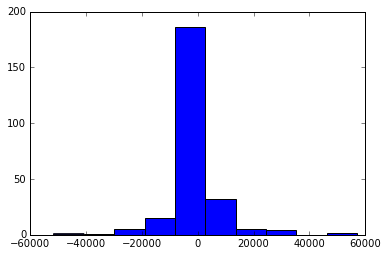

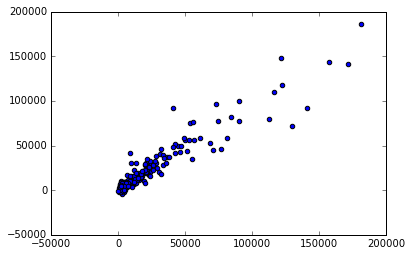

In [219]:
print mean_absolute_error(preds_df['true'],preds_df['new_weight'])
print mean_squared_error(preds_df['true'],preds_df['new_weight'])
print np.sqrt(mean_squared_error(preds_df['true'],preds_df['new_weight']))
print r2_score(preds_df['true'],preds_df['new_weight'])
                                         
                                         
plt.hist(preds_df['true']-preds_df['new_weight'])
plt.show()

plt.scatter(preds_df['true'],preds_df['new_weight'])

In [ ]:
# Metrics
print mean_absolute_error(y_holdout,preds)
print mean_squared_error(y_holdout,preds)
print np.sqrt(MSE_score)
print r2_score(y_holdout,preds)

plt.hist(y_holdout-preds)
plt.show()

plt.scatter(y_holdout,preds)